In [1]:
import os
import glob
import json
from itertools import product
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
plt.rc('legend',fontsize='large')
plt.rc('axes',labelsize='x-large')
plt.rc('text',usetex='true')
import seaborn as sns
import joblib
from packages.constants import HOME_PATH, SHOWER_SHAPES, STEP_PREFIX
from packages.utils import get_electron_label, get_jet_label
import packages.plotting as plotting
%matplotlib inline

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence


## Distribution plots

In [2]:
plot_cols = ['Boosted MC16 el', 'Data17 Zee el', 'Data17 Zee jet']
plot_ss = 'et'
step = 'L2Calo'
plot_ss = 'eratio'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[step] + plot_ss
stat = 'density'
datapath = os.path.join(HOME_PATH, 'data')
collision_path = os.path.join(datapath, 'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet', 
                              'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet_et4_eta4.parquet')
boosted_path = os.path.join(datapath, 'ided_mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2.parquet')

shower_shapes = [STEP_PREFIX[step] + ss for ss in SHOWER_SHAPES.keys()]
shower_shapes

['trig_L2_cl_reta', 'trig_L2_cl_eratio']

In [3]:
boosted_data = pd.read_parquet(boosted_path, columns=shower_shapes)
boosted_data.loc[:, 'source'] = 'Boosted MC16 el'
boosted_data.head()

,trig_L2_cl_reta,trig_L2_cl_eratio,source
0,0.925877,0.982229,Boosted MC16 el
1,0.988089,0.816197,Boosted MC16 el
2,0.935216,0.890477,Boosted MC16 el
3,0.962935,0.948033,Boosted MC16 el
4,0.670090,0.138930,Boosted MC16 el


In [4]:
add_cols = ['target', 'el_lhmedium', 'el_lhvloose']
collision_data = pd.read_parquet(collision_path, columns=shower_shapes + add_cols)
print(collision_data.shape)
jet_label = get_jet_label(collision_data, 'el_lhvloose')
collision_data['jet'] = jet_label
print(f'There are {jet_label.sum()} jets')
electron_label = get_electron_label(collision_data, 'el_lhmedium')
collision_data['electron'] = electron_label
print(f'There are {electron_label.sum()} electrons')
collision_data.loc[electron_label, 'source'] = 'Data17 Zee el'
collision_data.loc[jet_label, 'source'] = 'Data17 Zee jet'
collision_data = collision_data.loc[~collision_data['source'].isnull()]
collision_data.drop(add_cols, axis=1, inplace=True)
collision_data.shape

(198565, 5)
There are 93785 jets
There are 89782 electrons


(183567, 5)

### $E_{ratio}$

In [5]:
num_bins = 1000
bar_width = (ss_info['range'][1] - ss_info['range'][0])/num_bins
bins = np.linspace(*ss_info['range'], num=num_bins)
bin_start = bins[:-1]
bin_end = bins[1:]
in_range = collision_data[ss_col].between(*ss_info['range'])
binned_boosted, _ = np.histogram(boosted_data.loc[boosted_data[ss_col].between(*ss_info['range']), ss_col], bins=bins, density=True)
binned_electron, _ = np.histogram(collision_data.loc[collision_data['electron'] & in_range, ss_col], bins=bins, density=True)
binned_jets, _ = np.histogram(collision_data.loc[collision_data['jet'] & in_range, ss_col], bins=bins, density=True)
binned_data = np.column_stack([bin_start, bin_end, binned_boosted, binned_electron, binned_jets])
binned_data = pd.DataFrame(binned_data, columns=['bin_start', 'bin_end', 'Boosted MC16 el', 'Data17 Zee el', 'Data17 Zee jet'])
binned_data.tail(10)

,bin_start,bin_end,Boosted MC16 el,Data17 Zee el,Data17 Zee jet
989,0.989990,0.990991,49.972284,41.796445,2.078330
990,0.990991,0.991992,53.537754,45.405810,2.271663
991,0.991992,0.992993,60.069805,38.764578,1.304998
992,0.992993,0.993994,63.245302,40.208324,1.111665
993,0.993994,0.994995,68.565651,31.618036,1.111665
994,0.994995,0.995996,73.217474,25.626490,0.290000
995,0.995996,0.996997,66.462581,18.768697,0.531666
996,0.996997,0.997998,47.326037,14.293085,0.145000
997,0.997998,0.998999,18.718715,9.889660,0.096667
998,0.998999,1.000000,3.217279,6.135920,0.000000


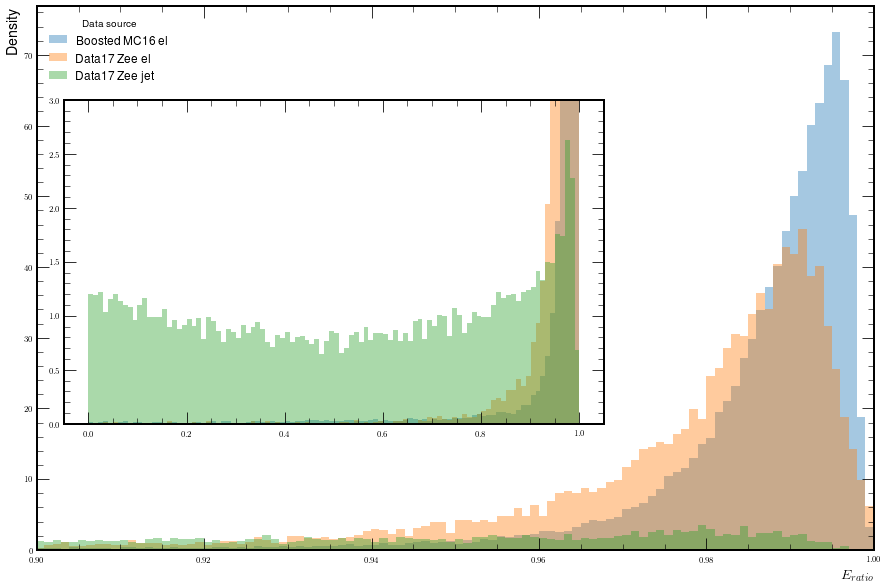

In [6]:
plot_ss = 'eratio'
ss_info = SHOWER_SHAPES[plot_ss]
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax = plotting.hist1d_from_bins_df(binned_data, cols=plot_cols, ax=ax, ylabel='Density', xlim=ss_info['electron_range'], xlabel=ss_info['label'], legend='Data source')
zoomed_ax = fig.add_axes([0.15, 0.3, 0.5, 0.45])
subsampled_binned = plotting.subsample_bins_df(binned_data, 10)
plotting.hist1d_from_bins_df(subsampled_binned, cols=plot_cols, ax=zoomed_ax, legend=False, ylim=(0, 3))

In [7]:
for col in plot_cols:
    print(col, (binned_data[col] * (binned_data['bin_end'] - binned_data['bin_start'])).sum())

Boosted MC16 el 1.0
Data17 Zee el 0.9999999999999999
Data17 Zee jet 1.0


In [8]:
for col in plot_cols:
    print(col, (subsampled_binned[col] * (subsampled_binned['bin_end'] - subsampled_binned['bin_start'])).sum())

Boosted MC16 el 1.0
Data17 Zee el 1.0000000000000002
Data17 Zee jet 1.0


## Eff plots